In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
df = pd.read_csv("data/winequality-red.csv")

# Exploratory Data Analysis

In [3]:
# View first five rows
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# View the summary statistics of overall dataset
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
# View distinct target class
df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

In [4]:
# Get feature vectors and labels
X = df[["fixed acidity", "volatile acidity", "citric acid", 
        "residual sugar", "chlorides", "free sulfur dioxide", 
        "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]]

<AxesSubplot: >

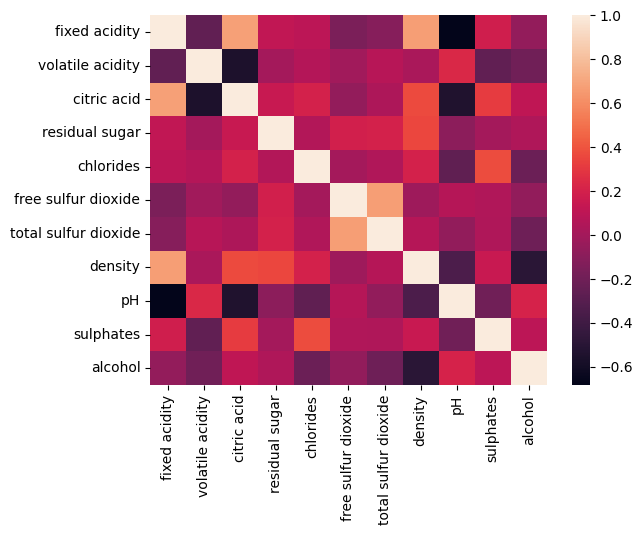

In [5]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In the above heatmap, we can see that, fixed acidity is correlated to density, and citric acid, and vice versa, free sulfur dioxide to total sulfur dioxide and vice versa, 

# Data Preprocessing

In [21]:
# Since the labels are in [5, 6, 7, 4, 8, 3] format
# We will need to modify the labels such that they 
# could be handled gracefully by downstream ML algorithm

encodings = {
    "3": 0,
    "4": 1,
    "5": 2,
    "6": 3,
    "7": 4,
    "8": 5
}

for ind, row in df.iterrows():
    df.loc[ind, "label"] = int(encodings[str(int(row["quality"]))])

In [31]:
# Get feature vectors and labels
X = df[["fixed acidity", "volatile acidity", "citric acid", 
        "residual sugar", "chlorides", "free sulfur dioxide", 
        "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]]
y = df["label"]

# Train/Test split

In [32]:
# Split dataset into train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.30, 
                                    random_state=42)

In [34]:
# Use StandardScale to normalize the data
std = StandardScaler()

X_scaler_train = std.fit_transform(X_train)
X_scaler_test = std.transform(X_test)

# Feature Selection using PCA

In [42]:
pca = PCA(n_components=11)

X_train_pca = pca.fit_transform(X_scaler_train)

Text(0.5, 1.0, 'Scree Plot')

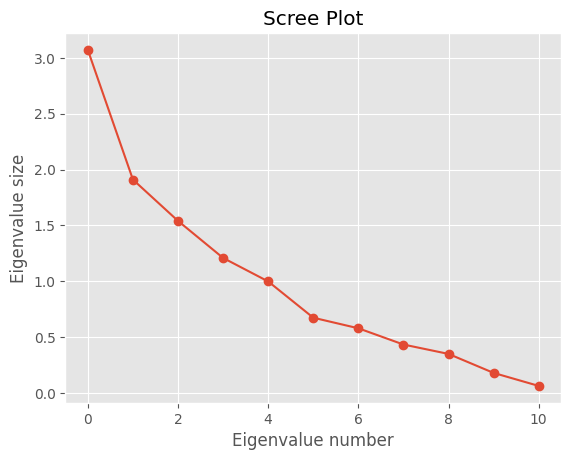

In [43]:
# Visualize which n_components is suitable for PCA
plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

Based on the above eigen value plot, we can see that the bend of the curve happens when, n_components=5, so we will be taking 5 components for our model.

In [44]:
pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_scaler_train)

In [45]:
X_test_pca = pca.transform(X_scaler_test)

# Model Building (Before PCA)

In [50]:
# Find optimal class
# Finding optimal k
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    n_init=12, random_state=0)
    kmeans.fit(X_scaler_train)
    wcss.append(kmeans.inertia_)

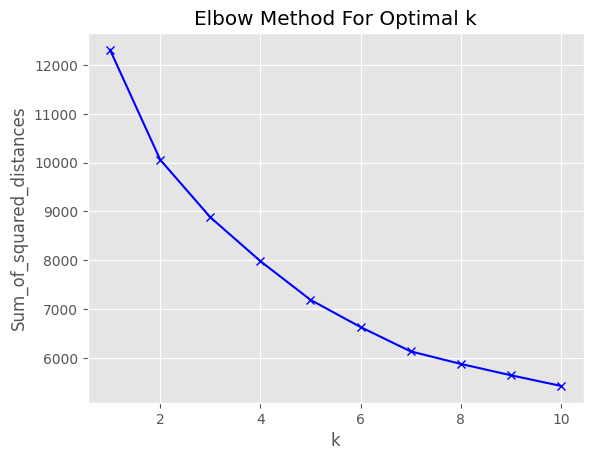

In [51]:
# Plot the above result
plt.plot(range(1, 11), wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=12, random_state=0)
kmeans.fit(X_scaler_train)

KMeans(n_clusters=6, n_init=12, random_state=0)

# Prediction and Evaluation (Before PCA)

In [54]:
y_pred = kmeans.predict(X_scaler_test)

In [55]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred) * 100

print("The accuracy of the model is: {0}%".format(acc))

The accuracy of the model is: 11.875%


# Model Building (After PCA)

In [46]:
# Find optimal class
# Finding optimal k
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    n_init=12, random_state=0)
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

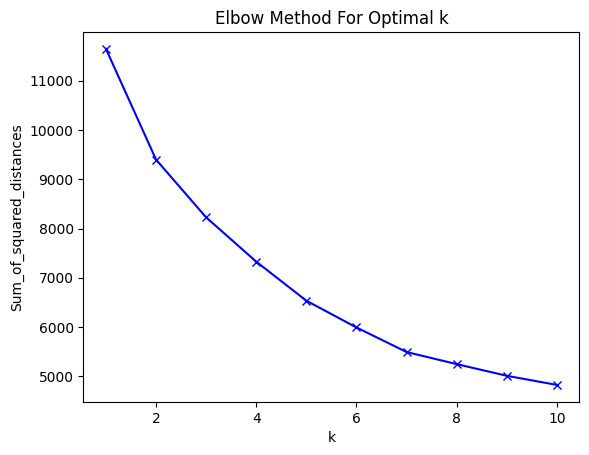

In [38]:
# Plot the above result
plt.plot(range(1, 11), wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the above graph, the optimal number of cluster to define is: 6

In [47]:
kmeans = KMeans(n_clusters=6, init='k-means++', 
                n_init=12, random_state=0)
kmeans.fit(X_train_pca)

KMeans(n_clusters=6, n_init=12, random_state=0)

# Prediction and Evaluation

In [48]:
y_pred = kmeans.predict(X_test_pca)

In [49]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred) * 100

print("The accuracy of the model is: {0}%".format(acc))

The accuracy of the model is: 20.625%


The overall accuracy of the model after applying PCA is only 20.6% which is clearly not sufficient for the prediction task. However, the overall accuracy increases from 11.8% to 20.6% after applying PCA, which shows that PCA is better to use for better model building and prediction.